In [0]:
from os.path import join
from google.colab import drive
# Montar el DRIVE
ROOT = "/content/drive"
drive.mount(ROOT)# Apuntar a la carpeta de trabajo
PROJ = "My Drive/MSI-MSS_project" # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.fftpack import fft
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import cv2
from skimage import data
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
from skimage.exposure import rescale_intensity
from PIL import Image
from sklearn.decomposition import PCA

In [0]:
set_completo = pd.read_pickle(join(PROJECT_PATH,'final_subset8mil_Color.pkl'))

In [0]:
set_completo["label"] = np.where((set_completo["label"]=="MSI"),0,1)

In [0]:
set_completo["label"].value_counts()

1    8000
0    8000
Name: label, dtype: int64

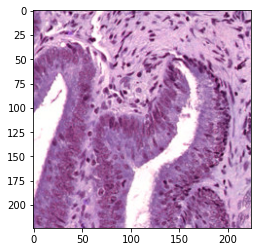

In [0]:
plt.imshow(set_completo["image_array"][4000])

In [0]:
def BnW(value):
  return cv2.cvtColor(value, cv2.COLOR_RGB2GRAY)

In [0]:
set_completo["bnw"] = set_completo["image_array"].apply(BnW)

In [0]:
def resizeImg(value):
  return cv2.resize(value, (100,100), interpolation=cv2.INTER_NEAREST)

In [0]:
set_completo["bnw_resize"] = set_completo["bnw"].apply(resizeImg)

In [0]:
def medianblur(value):
  return cv2.medianBlur(value.astype("float32"),3)

In [0]:
set_completo["blur"] = set_completo["bnw_resize"].apply(medianblur)

In [0]:
X = np.array(list(set_completo["blur"]))
X.shape

(16000, 100, 100)

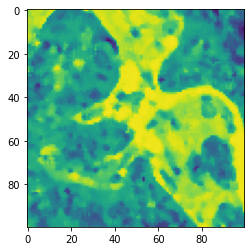

In [0]:
plt.imshow(X[10000])

In [0]:
X_dim = X.reshape(X.shape[0], -1)

In [0]:
X_dim.shape

(16000, 10000)

In [0]:
pca = PCA(n_components=50)
data_2d = pca.fit_transform(X_dim)

In [0]:
data_2d.shape

(16000, 50)

In [0]:
y=np.asarray(set_completo['label'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_2d, y, test_size=0.2)

In [0]:
model = RandomForestClassifier()

In [0]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
y_pred=model.predict(X_test)

In [0]:
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred, average='weighted'))
print("Recall", recall_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred, average='weighted'))
print("F1Score",f1_score(y_test, y_pred),"\n")

Accuracy 0.530625
Precision 0.5195288282703038
Precision 0.5309606119993859
Recall 0.5354632587859425
Recall 0.530625
F1Score 0.5273757079924482 



,gt,predicted,proba MSI,proba MSS
0,1,0,0.55,0.45
1,0,1,0.43,0.57
2,0,0,0.64,0.36
3,1,1,0.44,0.56
4,1,0,0.63,0.37


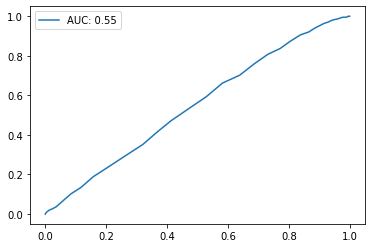

In [0]:
y_score = model.predict_proba(X_test)

#print(y_score)
roc = roc_curve(y_test, y_score[:,1])
display(pd.DataFrame({
    "gt":y_test,
    "predicted":y_pred,
    "proba MSI":y_score[:,0],
    "proba MSS":y_score[:,1]
}).head())

plt.plot(roc[0],roc[1])
plt.legend(["AUC: {}".format(round(roc_auc_score(y_test, y_score[:,1]),2))])

In [0]:
pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,860,775
1,727,838
